In [2]:
import pandas as pd
import numpy as np

In [3]:
df_kag = pd.read_csv('../data/synthetic_personal_finance_dataset.csv')
df_uci = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
# Common Column Mappings
job_map = {
    'Salesperson': 'services', 'Teacher': 'admin.', 'Manager': 'management',
    'Student': 'student', 'Accountant': 'admin.', 'Doctor': 'management',
    'Unemployed': 'unemployed', 'Driver': 'blue-collar', 'Engineer': 'technician'
}

edu_map = {
    'High School': 'high.school', 'PhD': 'university.degree',
    'Master': 'university.degree', 'Bachelor': 'university.degree',
    'Other': 'professional.course' 
}

def get_age_bucket(age):
    """Bins continuous age into demographic groups."""
    if age <= 25: return '18-25'
    elif age <= 35: return '26-35'
    elif age <= 50: return '36-50'
    elif age <= 65: return '51-65'
    else: return '66+'


# Logic for Responsiveness and Deposit Rate
def calculate_responsiveness(row):
    """
    Calculates propensity score based on behavioral features.
    """
    # Extract Features
    poutcome = row.get('prev_outcome', 'nonexistent') 
    campaign = max(1, float(row.get('campaign_count', 1)))
    job = row.get('uci_job', 'unknown')
    housing = row.get('housing_loan', 'unknown')
    previous = float(row.get('previous_count', 0))

    # Define Bimodal Peaks
    mu_low, sigma_low = 0.22, 0.07
    mu_high, sigma_high = 0.72, 0.1 

    # Base Propensity
    prob_enthusiast = 0.54 

    # Apply Modifiers
    
    # Campaign Fatigue
    if campaign <= 4: prob_enthusiast += 0.02
    elif 5 <= campaign <= 9: prob_enthusiast -= 0.10
    elif 10 <= campaign <= 20: prob_enthusiast -= 0.15
    elif campaign > 20: prob_enthusiast -= 0.25
    
    # Job Type
    job_modifiers = {
        'student': 0.10, 'unemployed': 0.05, 'retired': 0.02,
        'admin.': 0.0, 'management': 0.0, 'technician': 0.0,
        'services': -0.05, 'blue-collar': -0.08, 'housemaid': -0.05
    }
    prob_enthusiast += job_modifiers.get(job, 0.0)

    # Housing Loan
    if housing == 'yes': prob_enthusiast -= 0.05 
    elif housing == 'no': prob_enthusiast += 0.03

    # Previous Contacts
    if previous == 1: prob_enthusiast += 0.08 
    elif previous == 2: prob_enthusiast += 0.05 
    elif previous >= 3: prob_enthusiast -= 0.10 

    # Final Stochastic Selection
    if poutcome == 'success':
        return np.clip(np.random.normal(mu_high, sigma_high), 0.05, 0.98)
    elif poutcome == 'failure':
        return np.clip(np.random.normal(mu_low, sigma_low), 0.05, 0.98)
    else:
        final_prob = max(0.1, min(0.9, prob_enthusiast))
        is_enthusiast = np.random.choice([True, False], p=[final_prob, 1 - final_prob])
        return np.clip(np.random.normal(mu_high if is_enthusiast else mu_low, 
                                        sigma_high if is_enthusiast else sigma_low), 
                       0.05, 0.98)

# Interest Rate Calculator
def calculate_deposit_rate(euribor, campaign_count):
    """
    Derive a realistic offered interest rate.
    """
    # Base Market Rate (from 2008-2010 data)
    base_rate = float(euribor)
    
    # Bank Strategy Spread
    spread = np.random.uniform(0.1, 0.5)
    
    # Desperation Factor
    desperation_boost = 0.0
    if campaign_count > 5:
        desperation_boost = 0.2
        
    final_rate = base_rate + spread + desperation_boost
    
    return round(final_rate, 2)


# Sampler
def sample_synthetic_row(row, dist_l1, dist_l2, dist_l3, dist_l4, global_pool):
    # Define conditionals
    k1 = (row['age_bucket'], row['uci_job'], row['uci_edu']) 
    k2 = (row['uci_job'], row['uci_edu'])                    
    k3 = (row['uci_job'])                                    
    k4 = (row['age_bucket'])                                 
    
    match_pool = []
    source_level = "global"

    if k1 in dist_l1 and len(dist_l1[k1]) > 0: match_pool = dist_l1[k1]; source_level = "L1_exact"
    elif k2 in dist_l2 and len(dist_l2[k2]) > 0: match_pool = dist_l2[k2]; source_level = "L2_job_edu"
    elif k3 in dist_l3 and len(dist_l3[k3]) > 0: match_pool = dist_l3[k3]; source_level = "L3_job"
    elif k4 in dist_l4 and len(dist_l4[k4]) > 0: match_pool = dist_l4[k4]; source_level = "L4_age"
    else: match_pool = global_pool; source_level = "fallback"

    # Sample behavior profile
    behavior_profile = np.random.choice(match_pool)
    
    # Sample to calculate responsiveness
    temp_row = row.copy()
    temp_row['pdays'] = behavior_profile['pdays']
    temp_row['prev_outcome'] = behavior_profile['poutcome']
    temp_row['campaign_count'] = behavior_profile['campaign']
    temp_row['housing_loan'] = behavior_profile['housing']
    temp_row['previous_count'] = behavior_profile['previous']

    # Responsiveness Score
    resp_score = calculate_responsiveness(temp_row)

    # Interest Rate only if deposit is taken
    deposit_binary = 1 if behavior_profile['y'] == 'yes' else 0
    offered_rate = calculate_deposit_rate(behavior_profile['euribor3m'], behavior_profile['campaign']) if deposit_binary == 1 else np.nan

    return pd.Series({
        'responsiveness': resp_score,
        'deposit_interest_rate': offered_rate,
        'has_deposit': deposit_binary, 
        'marital_status': behavior_profile['marital'],
        'campaign_count': behavior_profile['campaign'],
        'previous_count': behavior_profile['previous'],
        'housing_loan': behavior_profile['housing'],
        'pdays': behavior_profile['pdays'],
        'prev_outcome': behavior_profile['poutcome'],
        'match_source': source_level
    })


# Main Pipeline
df_kag['age_bucket'] = df_kag['age'].apply(get_age_bucket)
df_kag['uci_job'] = df_kag['job_title'].map(job_map).fillna('unknown')
df_kag['uci_edu'] = df_kag['education_level'].map(edu_map).fillna('unknown')

df_uci['age_bucket'] = df_uci['age'].apply(get_age_bucket)

cols_to_sample = ['pdays', 'previous', 'poutcome', 'campaign', 'housing', 'marital', 'y', 'euribor3m']

dist_l1 = df_uci.groupby(['age_bucket', 'job', 'education'])[cols_to_sample].apply(lambda x: x.to_dict('records')).to_dict()
dist_l2 = df_uci.groupby(['job', 'education'])[cols_to_sample].apply(lambda x: x.to_dict('records')).to_dict()
dist_l3 = df_uci.groupby(['job'])[cols_to_sample].apply(lambda x: x.to_dict('records')).to_dict()
dist_l4 = df_uci.groupby(['age_bucket'])[cols_to_sample].apply(lambda x: x.to_dict('records')).to_dict()
global_pool = df_uci[cols_to_sample].to_dict('records')

new_features = [
    sample_synthetic_row(row._asdict(), dist_l1, dist_l2, dist_l3, dist_l4, global_pool)
    for row in df_kag.itertuples(index=False)
]
new_features = pd.DataFrame(new_features)

df_final = pd.concat([df_kag, new_features], axis=1)

final_cols = ['user_id', 'age', 'gender', 'marital_status', 'education_level', 'employment_status',
       'job_title', 'monthly_income_usd', 'monthly_expenses_usd',
       'savings_usd', 'has_deposit', 'deposit_interest_rate',
       'has_loan', 'loan_type', 'loan_amount_usd',
       'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct',
       'debt_to_income_ratio', 'credit_score', 'savings_to_income_ratio',
       'region', 'record_date', 'age_bucket',
       'responsiveness']

df_final = df_final[final_cols]

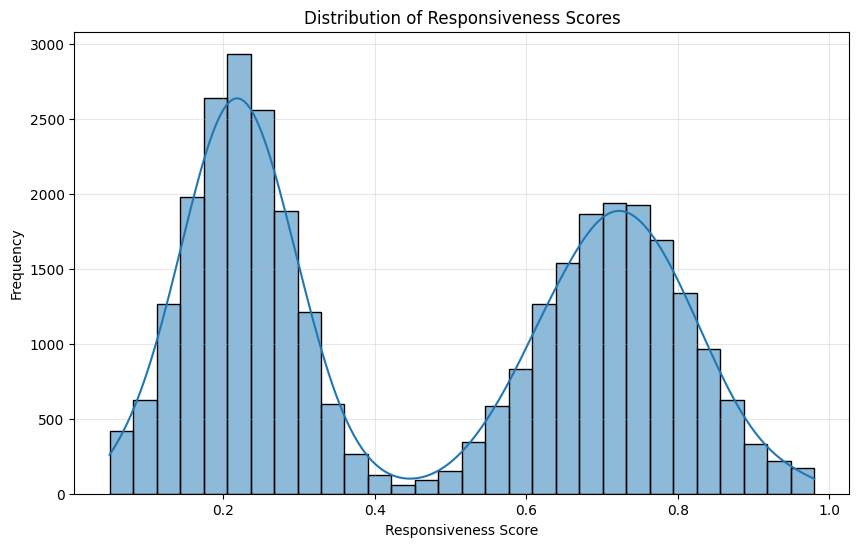

In [5]:
# Check if responsiveness column exists
import matplotlib.pyplot as plt
import seaborn as sns

if 'responsiveness' in df_final.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_final['responsiveness'], bins=30, kde=True)
    plt.title('Distribution of Responsiveness Scores')
    plt.xlabel('Responsiveness Score')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Column 'responsiveness' not found in df_final")
    print("Available columns:", df_final.columns.tolist())

In [6]:
df_final

,user_id,age,gender,marital_status,education_level,employment_status,job_title,monthly_income_usd,monthly_expenses_usd,savings_usd,...,loan_term_months,monthly_emi_usd,loan_interest_rate_pct,debt_to_income_ratio,credit_score,savings_to_income_ratio,region,record_date,age_bucket,responsiveness
0,U00001,56,Female,married,High School,Self-employed,Salesperson,3531.69,1182.59,367655.03,...,0,0.00,0.00,0.00,430,8.68,Other,2024-01-09,51-65,0.205321
1,U00002,19,Female,single,PhD,Employed,Salesperson,3531.73,2367.99,260869.10,...,36,4953.50,13.33,1.40,543,6.16,North America,2022-02-13,18-25,0.162983
2,U00003,20,Female,married,Master,Employed,Teacher,2799.49,1003.91,230921.21,...,0,0.00,0.00,0.00,754,6.87,Africa,2022-05-12,18-25,0.229039
3,U00004,25,Male,married,PhD,Employed,Manager,5894.88,4440.12,304815.51,...,24,4926.57,23.93,0.84,461,4.31,Europe,2023-10-02,18-25,0.650885
4,U00005,53,Female,single,PhD,Employed,Student,5128.93,4137.61,461509.48,...,0,0.00,0.00,0.00,516,7.50,Africa,2021-08-07,51-65,0.806334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32419,U32420,30,Female,married,High School,Employed,Salesperson,4266.87,1510.82,273669.70,...,120,6227.54,8.68,1.46,434,5.34,Europe,2024-02-25,26-35,0.711912
32420,U32421,51,Female,single,Master,Employed,Student,5725.78,4965.02,17247.57,...,12,7605.13,16.50,1.33,453,0.25,North America,2025-06-06,51-65,0.696709
32421,U32422,18,Female,single,Bachelor,Self-employed,Doctor,3282.38,2243.77,22081.21,...,0,0.00,0.00,0.00,391,0.56,Other,2025-07-20,18-25,0.209991
32422,U32423,36,Other,married,High School,Self-employed,Accountant,5035.99,4054.32,524039.88,...,0,0.00,0.00,0.00,596,8.67,Asia,2022-06-07,36-50,0.805817


In [7]:
df_final.to_parquet("../data/financial_data_enriched_1.parquet", index=False)